In [3]:
import sys
!{sys.executable} -m pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [105]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from time import perf_counter

In [248]:
# configuring figure/plot params
custom_params = {'figure.figsize':(16, 9)} 
sns.set_theme(style="whitegrid", font_scale=1.3, rc=custom_params)

In [6]:
# loading dataset (it's a bit slow)
mnist_data = pd.read_csv('mnist.csv').values

In [7]:
labels = mnist_data[:, 0]  # 0 to 9
digits = mnist_data[:, 1:] # 42000 digits
print(labels, len(labels))
print(digits, len(digits[0]))
mnist_df = pd.DataFrame(mnist_data)
mnist_df.head()
# first column is label, all (784) other columns are pixel values (0-255)

[1 0 1 ... 7 6 9] 42000
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 784


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Exploration / Pre-Processing
Exploring data and plotting cool stuff

In [3]:
unique, counts = np.unique(labels, return_counts=True)
print(unique, counts)

NameError: name 'np' is not defined

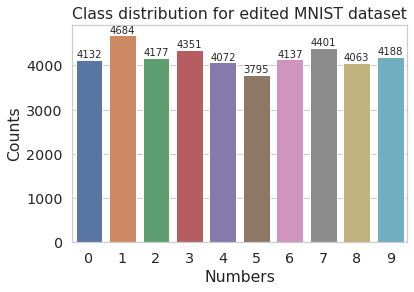

In [8]:
ax = sns.barplot(x=unique,y=counts)
ax.bar_label(ax.containers[0])
plt.title("Class distribution for edited MNIST dataset")
plt.ylabel("Counts")
plt.xlabel("Numbers")
plt.show()

fig = ax.get_figure()
fig.savefig("class_dist.png", dpi=300) 
# TODO: maybe plot mean and std in this plot?

In [128]:
# resizing digits for future use on complex models
digitsResized = np.zeros((len(digits), 14*14))

for i, d in enumerate(digits):
    _d = np.reshape(d, (28, 28)).astype('float32')
    resized_d = cv2.resize(_d, (14, 14))
    d_ = np.reshape(resized_d, (1, 14*14))
    digitsResized[i] = d_

In [10]:
# randomly print one number from each class
def print_one_from_each(filename, digits, img_size):
    fig = plt.figure(figsize=(16,8))
    cols, rows = 5, 2
    for i in range(1, (cols*rows)+1):
        fig.add_subplot(rows, cols, i)
        index = np.where(labels == i-1)[0][0]
        plt.imshow(digits[index].reshape(img_size, img_size))
        plt.xlabel(str(labels[index]))
    plt.show()
    fig.savefig(f"{filename}.png", dpi=300)

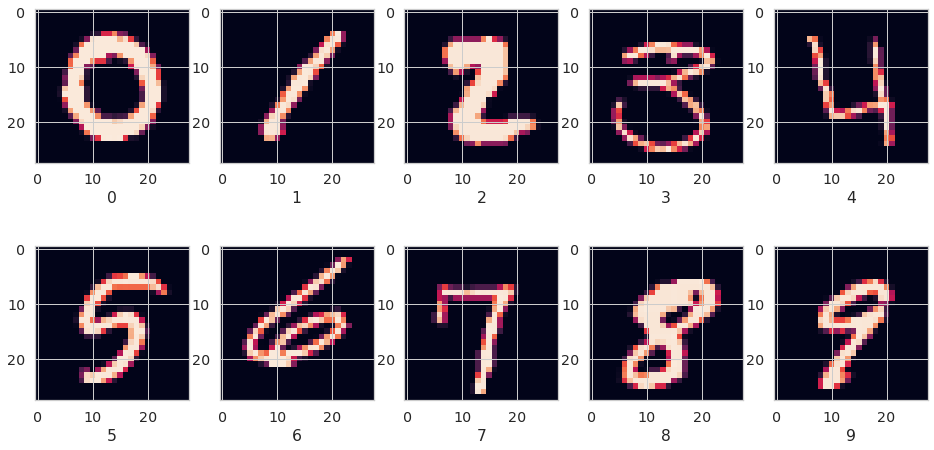

In [11]:
print_one_from_each("28_digits", digits, 28)

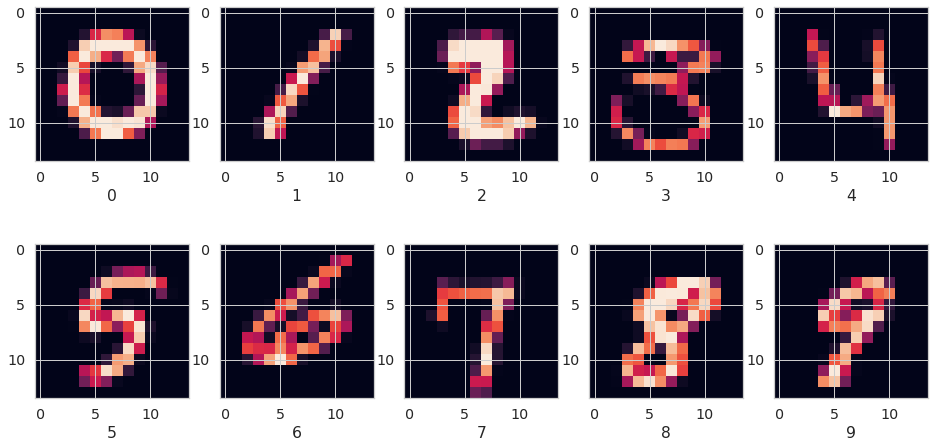

In [12]:
# visually sampling the resized data
print_one_from_each("14_digits", digitsResized, 14)

#### Drop useless features

Useless features are those with constant values across all data points, hence cannot be used to distinguish between data.

In [2]:
def filterConstantFeature(matrix, idx):
    return False if np.var(matrix[:, idx]) == 0.0 else True

cols_digits = list(range(0, len(digits[0])))
usefulCols_digits = [filterConstantFeature(digits, i) for i in cols_digits]
digitsFiltered = digits[:, usefulCols_digits]

cols_digitsResized = list(range(0, len(digitsResized[0])))
usefulCols_digitsResized = [filterConstantFeature(digitsResized, i) for i in cols_digitsResized]
digitsResizedFiltered = digitsResized[:, usefulCols_digitsResized]     
# DATA: digits -> resized to 14x14 -> dropped constant features.

# print(np.shape(digitsResized))
# print(np.shape(digitsResizedFiltered))

NameError: name 'digits' is not defined

In [14]:
# given some restriction on later parts of the assignment,
# should we train ALL models with said restrictions for consistency's sake?
# those being only training on 5000 samples and testing on the remaining (37000) samples

# Part 1. INK Feature Models
- Model 1. (Zero mean and SD=1) Multinomial Logit -> Ink Feature
- Model 2. (Zero mean and SD=1) MN Logit -> Ink Feature + Our own special feature

In [15]:
# preparing to build both features
def print_feature(feat, feat_mean, feat_std):
    print(f"{feat}\n{feat_mean}\n{feat_std}\n")
    print(f"{np.size(feat)}, {np.size(feat_mean)}, {np.size(feat_std)}")

In [16]:
# creating ink feature
ink = np.array([sum(row) for row in digits])
print(f"Ink Feature:\n {ink}")

Ink Feature:
 [16649 44609 13425 ... 31504 26381 18178]


In [17]:
ink_mean = [np.mean(ink[labels == i]) for i in range(10)] # mean for each digit
ink_std = [np.std(ink[labels == i]) for i in range(10)] # std for each digit
print_feature(ink, ink_mean, ink_std)

[16649 44609 13425 ... 31504 26381 18178]
[34632.40755082285, 15188.466268146884, 29871.099353603066, 28320.188002757986, 24232.72249508841, 25835.920421607378, 27734.917331399563, 22931.244262667577, 30184.148412503077, 24553.75]
[8461.892043158483, 4409.461697281539, 7653.006198983366, 7574.104535679545, 6374.633457092554, 7526.602988920305, 7530.503187255003, 6168.3408781754315, 7777.396357381105, 6465.231330430596]

42000, 10, 10


In [145]:
def line_counter(array):
    counter = 0
    line_start = False
    for pixel in array:
        if line_start == False and pixel > 0 :
            line_start = True
        if line_start == True and pixel < 1:
            line_start = False
            counter += 1
    return counter

In [146]:
# our new feature - number of lines (horizontal and vertically)
# how many one-line pixels are enveloped by zero pixels
# rows and columns; 0 has a LOT of whitespace, 1 doesn´t have that much
def build_line_feature(digits, max_count=6, img_size=28):
    """
    building line counter feature
    digits: array for all digits and all pixel values
    max_count: max number of lines being counted
    img_size: size of the image (default is 28x28)
    """ 
    num_samples = len(digits)
    df_lines = pd.DataFrame(index=(range(len(digits))))
    # setting up empty dataframe
    directions = ['h', 'v']
    for direction in directions:
        for i in range(max_count):
            new_col = f"{direction}_{i}_line"
            df_lines[new_col] = 0
    
    
    for index, digit in enumerate(digits): # each digit has img_size*img_size (784) elements
        offset, x = 0, 0
        for i in range(img_size): # img_size rows and columns on each digit
            row = digit[(0+offset):(img_size+offset)]
            col_indexes = np.arange(start=x, stop=(img_size*img_size), step=img_size)
            col = np.array([digit[x] for x in col_indexes])
            # print(f"\n{row}\n{column}")
            
            h_count, v_count = line_counter(row), line_counter(col)
            df_lines.at[index, f"h_{h_count}_line"] += 1
            df_lines.at[index, f"v_{v_count}_line"] += 1
            
            offset += img_size
            x += 1
        # plt.imshow(digit.reshape(img_size, img_size))
        # plt.show()
        # break
        
    return df_lines

In [148]:
# don´t run this unless stricly necessary
start = perf_counter()
#df_lines = build_line_feature(digits)
end = perf_counter()
print(f"Took {end-start:.2f} seconds to build line counting feature.")

Took 208.31 seconds to build line counting feature.


In [149]:
df_lines.describe()

,h_0_line,h_1_line,h_2_line,h_3_line,h_4_line,h_5_line,v_0_line,v_1_line,v_2_line,v_3_line,v_4_line,v_5_line
count,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000
mean,8.256738,14.447048,5.090500,0.204690,0.001000,0.000024,12.365024,7.999024,5.858357,1.746357,0.031095,0.000143
std,0.981878,4.029458,3.813827,0.737722,0.034489,0.004880,3.854687,3.602049,3.588119,2.451583,0.239317,0.013801
min,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,12.000000,2.000000,0.000000,0.000000,0.000000,9.000000,5.000000,3.000000,0.000000,0.000000,0.000000
50%,8.000000,15.000000,5.000000,0.000000,0.000000,0.000000,12.000000,8.000000,6.000000,0.000000,0.000000,0.000000
75%,8.000000,18.000000,8.000000,0.000000,0.000000,0.000000,14.000000,10.000000,8.000000,3.000000,0.000000,0.000000
max,19.000000,20.000000,19.000000,11.000000,3.000000,1.000000,26.000000,20.000000,19.000000,15.000000,7.000000,2.000000


In [200]:
h_pass_sum = df_lines.iloc[:, :6].sum() 
v_pass_sum = df_lines.iloc[:, 6:].sum()
h_pass_sum = h_pass_sum.rename({"h_0_line": "0 lines", "h_1_line": "1 line", "h_2_line": "2 lines", "h_3_line": "3 lines", "h_4_line": "4 lines", "h_5_line": "5 lines"})
v_pass_sum = v_pass_sum.rename({"v_0_line": "0 lines", "v_1_line": "1 line", "v_2_line": "2 lines", "v_3_line": "3 lines", "v_4_line": "4 lines", "v_5_line": "5 lines"})

print(h_pass_sum)
print(v_pass_sum)

0 lines    346783
1 line     606776
2 lines    213801
3 lines      8597
4 lines        42
5 lines         1
dtype: int64
0 lines    519331
1 line     335959
2 lines    246051
3 lines     73347
4 lines      1306
5 lines         6
dtype: int64


Text(0, 0.5, 'Total Sum')

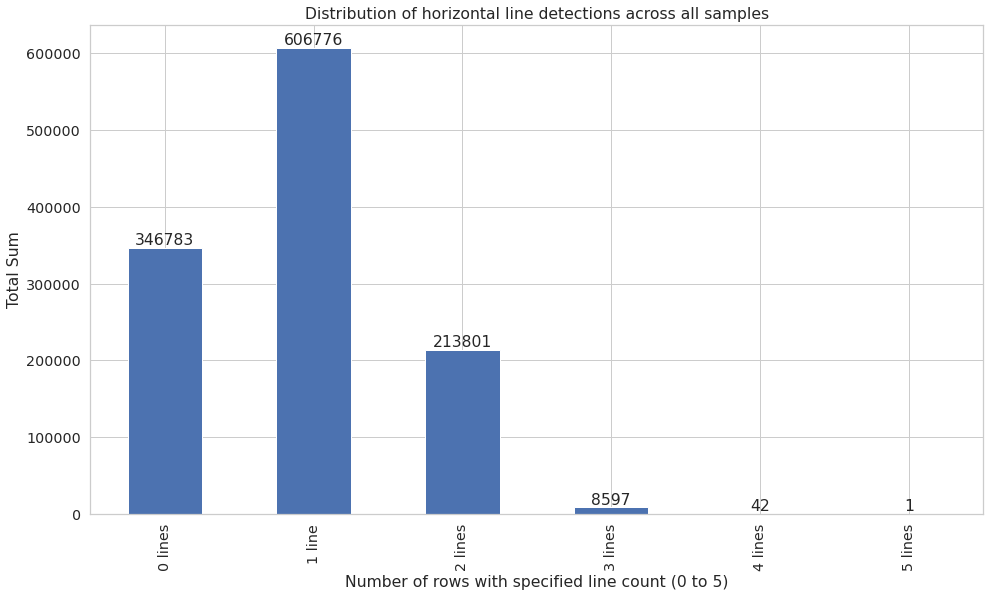

In [202]:
ax = h_pass_sum.plot(kind="bar")
ax.bar_label(ax.containers[0])
plt.title("Distribution of horizontal line detections across all samples")
plt.xlabel("Number of rows with specified line count (0 to 5)")
plt.ylabel("Total Sum")

Text(0, 0.5, 'Total Sum')

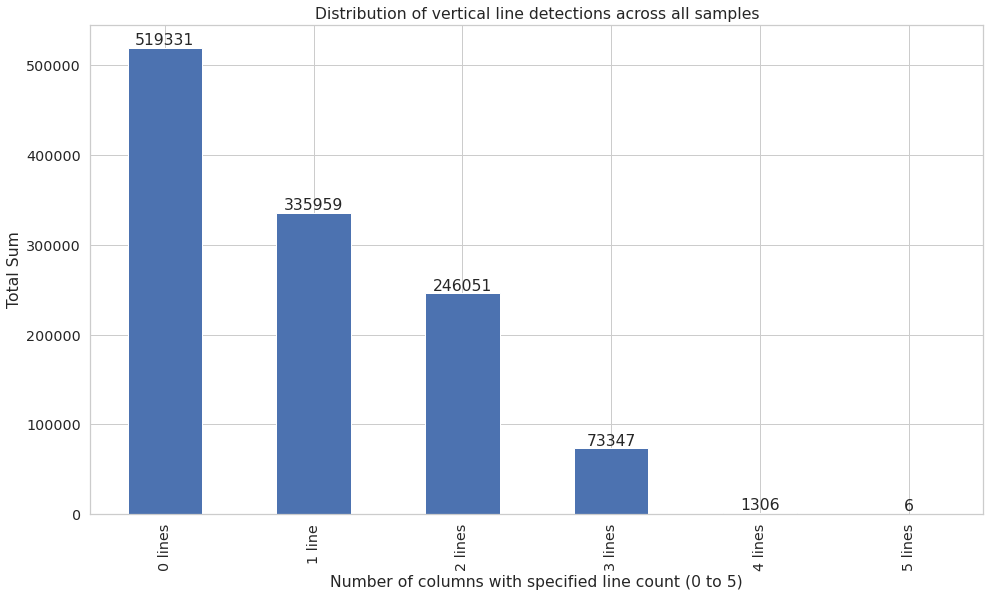

In [203]:
ax = v_pass_sum.plot(kind="bar")
ax.bar_label(ax.containers[0])
plt.title("Distribution of vertical line detections across all samples")
plt.xlabel("Number of columns with specified line count (0 to 5)")
plt.ylabel("Total Sum")

In [158]:
df_lines.head()

,h_0_line,h_1_line,h_2_line,h_3_line,h_4_line,h_5_line,v_0_line,v_1_line,v_2_line,v_3_line,v_4_line,v_5_line
0,8,20,0,0,0,0,12,16,0,0,0,0
1,8,10,10,0,0,0,8,11,9,0,0,0
2,8,20,0,0,0,0,24,3,1,0,0,0
3,8,6,14,0,0,0,12,14,2,0,0,0
4,8,9,11,0,0,0,8,10,10,0,0,0


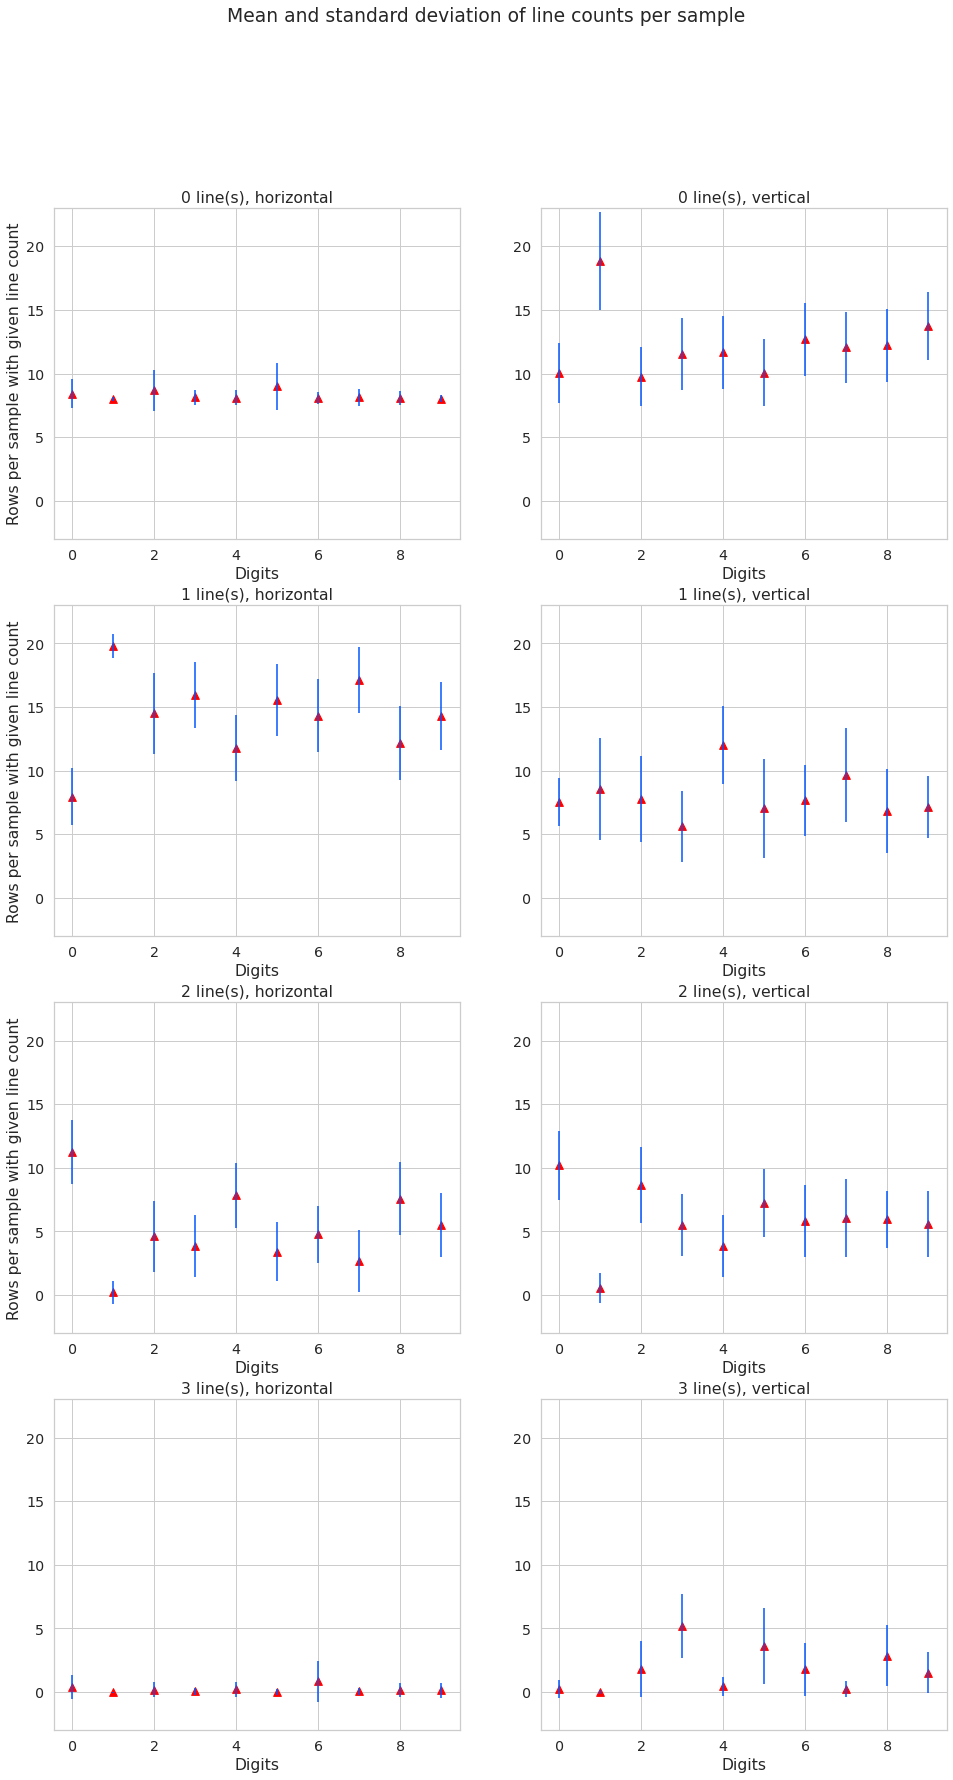

In [238]:
fig, axs = plt.subplots(4, 2, figsize=(16, 28))
directions = ["horizontal", "vertical"]

for number in range(4): # 0 lines, 1 line, 2 lines, 3 lines
    for index, direction in enumerate(directions): # horizontal on top, vertical on bottom
        col = f"{direction[0]}_{number}_line"
        col_filter = df_lines[col]
        line_mean = [np.mean(col_filter[labels == i]) for i in range(10)]
        line_std = [np.std(col_filter[labels == i]) for i in range(10)]
        
        axs[number, index].set_ylim(-3, 23)
        axs[number, index].scatter(
            list(range(0, 10, 1)),
            line_mean,
            label='Line Mean',
            marker='^',
            color='#F00',
            s=60
        )
        axs[number, index].errorbar(
            list(range(0, 10, 1)),
            line_mean,
            yerr=line_std,
            color='#05F',
            linestyle='',
            label='Line STD'
        )
        axs[number, index].set_title(f"{number} line(s), {direction}")
        axs[number, index].set_xlabel("Digits")

axs[0, 0].set_ylabel("Rows per sample with given line count")
axs[1, 0].set_ylabel("Rows per sample with given line count")
axs[2, 0].set_ylabel("Rows per sample with given line count")
axs[2, 0].set_ylabel("Rows per sample with given line count")
fig.suptitle("Mean and standard deviation of line counts per sample")
plt.show()

In [157]:
# scaling values manually
df_lines_scaled = df_lines.copy()
for col in df_lines.columns:
    mean = df_lines[col].mean()
    std = df_lines[col].std()
    print(col, mean, std)
    df_lines_scaled[col] = df_lines_scaled[col].apply(lambda x: (x-mean)/std)

df_lines_scaled.head()

h_0_line 8.256738095238095 0.9818781468834169
h_1_line 14.44704761904762 4.029458401630518
h_2_line 5.0905 3.8138268332074525
h_3_line 0.2046904761904762 0.7377220442171486
h_4_line 0.001 0.03448919413399204
h_5_line 2.380952380952381e-05 0.004879500364742666
v_0_line 12.365023809523809 3.854686938642684
v_1_line 7.999023809523809 3.6020494653558037
v_2_line 5.858357142857143 3.588119421367713
v_3_line 1.746357142857143 2.451583321737202
v_4_line 0.031095238095238096 0.2393168298259034
v_5_line 0.00014285714285714287 0.01380073610654082


,h_0_line,h_1_line,h_2_line,h_3_line,h_4_line,h_5_line,v_0_line,v_1_line,v_2_line,v_3_line,v_4_line,v_5_line
0,-0.261477,1.378089,-1.334749,-0.277463,-0.028995,-0.00488,-0.094696,2.221229,-1.632710,-0.712338,-0.129933,-0.010351
1,-0.261477,-1.103634,1.287290,-0.277463,-0.028995,-0.00488,-1.132394,0.833130,0.875568,-0.712338,-0.129933,-0.010351
2,-0.261477,1.378089,-1.334749,-0.277463,-0.028995,-0.00488,3.018397,-1.387828,-1.354012,-0.712338,-0.129933,-0.010351
3,-0.261477,-2.096323,2.336105,-0.277463,-0.028995,-0.00488,-0.094696,1.665989,-1.075315,-0.712338,-0.129933,-0.010351
4,-0.261477,-1.351806,1.549494,-0.277463,-0.028995,-0.00488,-1.132394,0.555510,1.154266,-0.712338,-0.129933,-0.010351


In [247]:
# helper function to print results
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_results(filename, y_test, y_pred):
    print(f"\nResults for {filename}\n")
    print(classification_report(y_test, y_pred, zero_division=0)) # hiding zero division warn
    cm = confusion_matrix(y_test, y_pred, labels=scaled_logit.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=scaled_logit.classes_)
    disp.plot()
    plt.title(filename)
    plt.grid(visible=None)
    plt.show()
    # TODO: how to save this as pic?
    disp.figure_.savefig(f"{filename}.png", dpi=300)

## Model 1. MN Logit (only INK feature)

In [255]:
# pipeline setup to facilitate modelling; consolidate training and testing datasets
# https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

l1f_train, l1f_test, y_l1f_train, y_l1f_test = train_test_split(ink.reshape(-1,1), labels, 
                                                    random_state=42, 
                                                    test_size=0.2)

# this pipeline logic is so we don´t leak data from the test set into the training set
scaled_logit = make_pipeline(StandardScaler(), LogisticRegression())
start_t1 = perf_counter()
scaled_logit.fit(l1f_train, y_l1f_train)  # apply scaling on training data
scaled_logit.score(l1f_test, y_l1f_test)
end_t1 = perf_counter()
print(f"Took {end_t1-start_t1:.2f} seconds to train 1st LOGIT model (ink feature)")
y_l1f_pred = scaled_logit.predict(l1f_test)

Took 0.51 seconds to train 1st LOGIT model (ink feature)



Results for Multinomial Logit (Ink Feature) Confusion Matrix

              precision    recall  f1-score   support

           0       0.25      0.58      0.35       816
           1       0.43      0.84      0.57       909
           2       0.14      0.10      0.12       846
           3       0.14      0.20      0.16       937
           4       0.00      0.00      0.00       839
           5       0.00      0.00      0.00       702
           6       0.09      0.02      0.04       785
           7       0.16      0.38      0.22       893
           8       0.00      0.00      0.00       835
           9       0.16      0.08      0.11       838

    accuracy                           0.23      8400
   macro avg       0.14      0.22      0.16      8400
weighted avg       0.14      0.23      0.16      8400



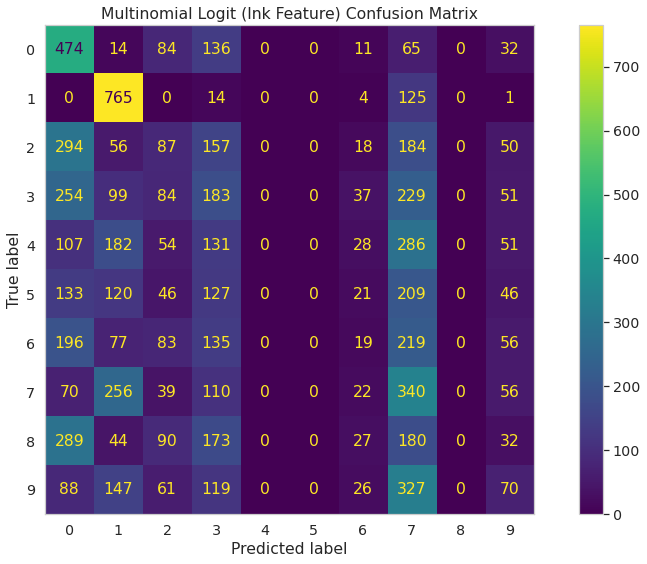

In [256]:
show_results("Multinomial Logit (Ink Feature) Confusion Matrix", y_l1f_test, y_l1f_pred)

## Model 2. MN Logit (INK feature + Our Feature)

In [259]:
df_line_ink = df_lines.copy()
df_line_ink["ink"] = ink
l2f_train, l2f_test, y_l2f_train, y_l2f_test = train_test_split(df_line_ink, labels, 
                                                    random_state=42, 
                                                    test_size=0.2)

# this pipeline logic is so we don´t leak data from the test set into the training set
scaled_logit = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
start_t2 = perf_counter()
scaled_logit.fit(l2f_train, y_l2f_train)  # apply scaling on training data
scaled_logit.score(l2f_test, y_l2f_test)
end_t2 = perf_counter()
print(f"Took {end_t2-start_t2:.2f} seconds to train 2nd LOGIT model (both features)")
y_l2f_pred = scaled_logit.predict(l2f_test)

Took 3.34 seconds to train 2nd LOGIT model (both features)



Results for Multinomial Logit (Both Features) Confusion Matrix

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       816
           1       0.90      0.96      0.93       909
           2       0.42      0.41      0.42       846
           3       0.58      0.63      0.61       937
           4       0.73      0.79      0.76       839
           5       0.45      0.41      0.43       702
           6       0.46      0.32      0.38       785
           7       0.55      0.62      0.58       893
           8       0.56      0.55      0.56       835
           9       0.45      0.42      0.43       838

    accuracy                           0.61      8400
   macro avg       0.60      0.61      0.60      8400
weighted avg       0.60      0.61      0.61      8400



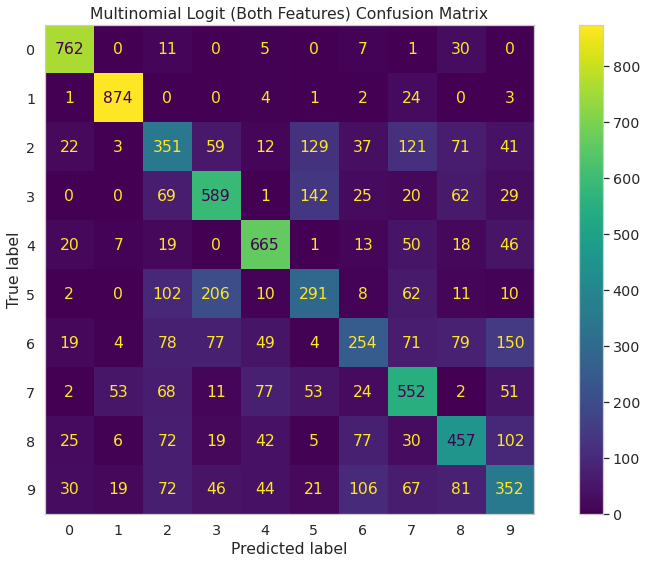

In [260]:
show_results("Multinomial Logit (Both Features) Confusion Matrix", y_l2f_test, y_l2f_pred)

In [264]:
print(df_lines)
l3f_train, l3f_test, y_l3f_train, y_l3f_test = train_test_split(df_lines, labels, 
                                                    random_state=42, 
                                                    test_size=0.2)

# this pipeline logic is so we don´t leak data from the test set into the training set
scaled_logit = make_pipeline(StandardScaler(), LogisticRegression())
start_t3 = perf_counter()
scaled_logit.fit(l3f_train, y_l3f_train)  # apply scaling on training data
scaled_logit.score(l3f_test, y_l3f_test)
end_t3 = perf_counter()
print(f"Took {end_t3-start_t3:.2f} seconds to train 2nd LOGIT model (both features)")
y_l3f_pred = scaled_logit.predict(l3f_test)

       h_0_line  h_1_line  h_2_line  h_3_line  h_4_line  h_5_line  v_0_line  \
0             8        20         0         0         0         0        12   
1             8        10        10         0         0         0         8   
2             8        20         0         0         0         0        24   
3             8         6        14         0         0         0        12   
4             8         9        11         0         0         0         8   
...         ...       ...       ...       ...       ...       ...       ...   
41995         8         7        13         0         0         0         8   
41996         8        20         0         0         0         0        23   
41997         8        17         3         0         0         0        11   
41998         8        14         4         2         0         0        12   
41999         8        10        10         0         0         0        14   

       v_1_line  v_2_line  v_3_line  v_4_line  v_5_


Results for Multinomial Logit (Vertical + Horizontal Pass Feature) Confusion Matrix

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       816
           1       0.90      0.96      0.93       909
           2       0.39      0.38      0.39       846
           3       0.57      0.66      0.61       937
           4       0.68      0.75      0.71       839
           5       0.46      0.35      0.40       702
           6       0.48      0.27      0.35       785
           7       0.47      0.61      0.53       893
           8       0.53      0.47      0.50       835
           9       0.39      0.37      0.38       838

    accuracy                           0.58      8400
   macro avg       0.56      0.57      0.56      8400
weighted avg       0.57      0.58      0.57      8400



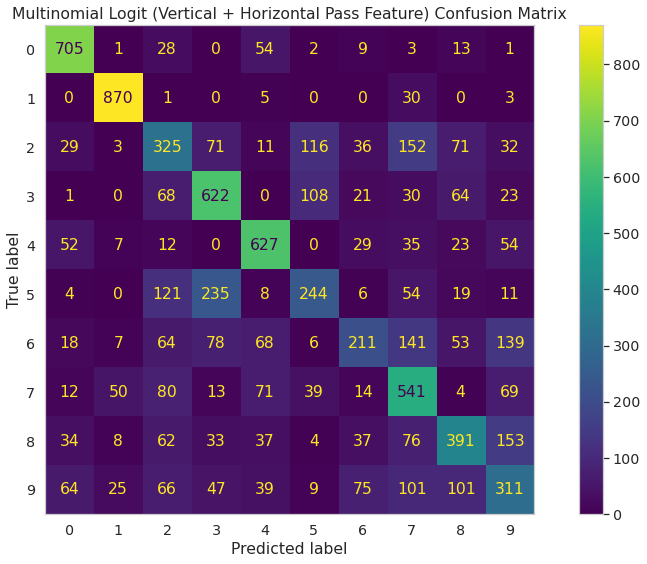

In [265]:
show_results("Multinomial Logit (Vertical + Horizontal Pass Feature) Confusion Matrix", y_l3f_test, y_l3f_pred)

# Part 2. All Pixel Values Models
_**NOTE: Both with 196 (14*14 pixels) features (all resized pixel values)**_

- Model 3. (Regularized?) MN Logit (w/ LASSO penalty) 
- Model 4. Support Vector Machines (SVM)

In [1]:
# separating training and test samples for both part 2 models
p2_features = digitsResized
p2_train, p2_test, y_p2_train, y_p2_test = train_test_split(p2_features, labels, 
                                                    random_state=42, 
                                                    test_size=37000)

NameError: name 'digitsResized' is not defined

### MN Logit (w/ LASSO penalty)

In [130]:
from sklearn.linear_model import LogisticRegression

# saga is the only solver that supports l1 penalty and multi-class problems
# arr = np.array([ink_mean, ink_std])
# print(pd.DataFrame(arr))
# print(df.loc[:, (df.sum() > 0).all()])

p2_logit = make_pipeline(
    StandardScaler(), 
    LogisticRegression(C=0.5, max_iter=1000, penalty='l1', solver='saga')
)

start_p2m1 = perf_counter()
p2_logit.fit(p2_train, y_p2_train)
p2_logit.score(p2_test, y_p2_test)
end_p2m1 = perf_counter()
print(f"Took {end_p2m1-start_p2m1:.2f} seconds to train LOGIT model (all pixel values)")
p2_logit_pred = p2_logit.predict(p2_test)

Took 235.71 seconds to train LOGIT model (all pixel values)


/usr/lib64/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Results for Multinomial Logit (14x14 pixel values) Confusion Matrix

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2468
           1       0.95      0.97      0.96      2797
           2       0.92      0.90      0.91      2527
           3       0.89      0.88      0.89      2634
           4       0.92      0.92      0.92      2485
           5       0.87      0.87      0.87      2233
           6       0.94      0.95      0.95      2489
           7       0.93      0.93      0.93      2647
           8       0.90      0.88      0.89      2428
           9       0.89      0.89      0.89      2492

    accuracy                           0.92     25200
   macro avg       0.92      0.92      0.92     25200
weighted avg       0.92      0.92      0.92     25200



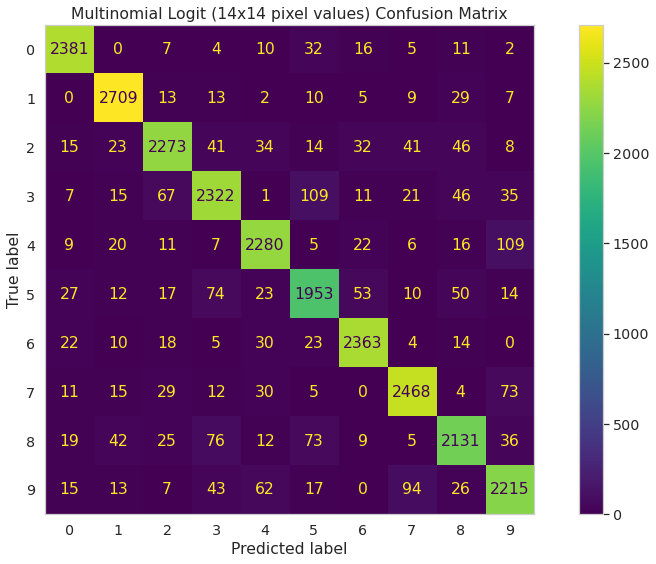

In [252]:
show_results("Multinomial Logit (14x14 pixel values) Confusion Matrix", y_p2_test, p2_logit_pred)

### SVM + Grid Search

In [132]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from tqdm import tqdm

# === Note on kernels and params ===
# rbf: gamma
# linear: x, x'
# sigmoid: coef0
# poly: degree, coef0
#   but coef0 can be safely left unchanged "in most cases" according to 
# https://stackoverflow.com/questions/21390570/scikit-learn-svc-coef0-parameter-range

paramGrid = {
    'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
    'C': [0.1, 0.5, 0.9, 1.5, 2, 2.5],
    'degree': [0.5, 1, 2, 5],
    'gamma': ['auto', 'scale'],
}

grid = GridSearchCV(SVC(), paramGrid, refit=True, verbose=3)
start_p2m2 = perf_counter()
grid.fit(p2_train, y_p2_train)
end_p2m2 = perf_counter()
print(f"Took {end_p2m2-start_p2m2:.2f} seconds to GridSearchCV SVM model (all pixel values)")

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5] END C=0.1, degree=0.5, gamma=auto, kernel=rbf;, score=0.113 total time= 1.3min
[CV 2/5] END C=0.1, degree=0.5, gamma=auto, kernel=rbf;, score=0.113 total time= 1.4min
[CV 3/5] END C=0.1, degree=0.5, gamma=auto, kernel=rbf;, score=0.112 total time= 1.3min


KeyboardInterrupt: 

In [133]:
p2_svc = make_pipeline(
    StandardScaler(), 
    SVC(kernel='poly', C=2, degree=2)
)

start_p2m2 = perf_counter()
p2_svc.fit(p2_train, y_p2_train)
p2_svc.score(p2_test, y_p2_test)
end_p2m2 = perf_counter()
print(f"Took {end_p2m2-start_p2m2:.2f} seconds to train SVC model (all pixel values)")
p2_svc_pred = p2_svc.predict(p2_test)

Took 235.71 seconds to train SVC model (all pixel values)



Results for SVM (14x14 pixel values) Confusion Matrix

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2468
           1       0.98      0.98      0.98      2797
           2       0.96      0.96      0.96      2527
           3       0.95      0.94      0.95      2634
           4       0.97      0.95      0.96      2485
           5       0.95      0.96      0.95      2233
           6       0.98      0.97      0.97      2489
           7       0.97      0.96      0.96      2647
           8       0.93      0.95      0.94      2428
           9       0.94      0.94      0.94      2492

    accuracy                           0.96     25200
   macro avg       0.96      0.96      0.96     25200
weighted avg       0.96      0.96      0.96     25200



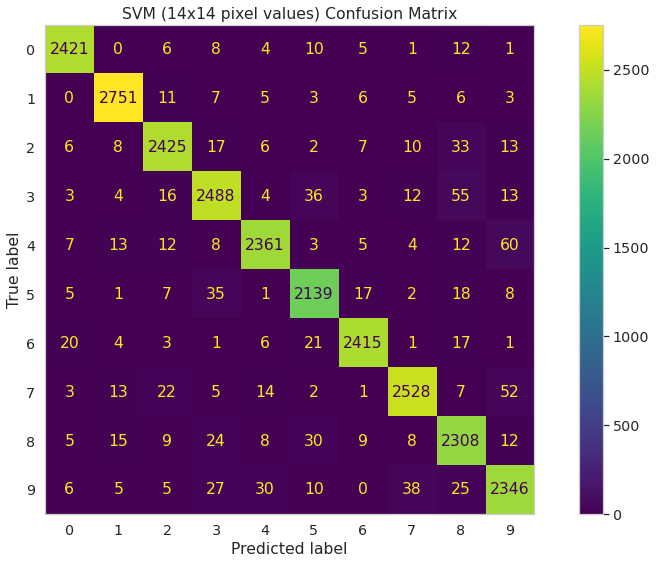

In [253]:
show_results("SVM (14x14 pixel values) Confusion Matrix", y_p2_test, p2_svc_pred)